In [1]:
import numpy as np
import pandas as pd 
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

## Data Cleaning 

In [2]:
df = pd.read_csv('wiki_data.csv')
df=df[df.columns[1:]]
nan_values = df[df.columns[:26]].isna().sum().sort_values()
columns_keeping = nan_values[nan_values<6000].index
df = df[columns_keeping]
df['Based on'] = df['Based on'].apply(lambda x: 0 if pd.isna(x) else 1)

C:\Users\jacob\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (37,49,69,70,72,73,76,79,83,101,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,135,136,137,138,139,140,141,142,146,147,148,149,150,151,152,156,159,160,166,167,168,169,170,171,172,173,174,176,177,178,179,180,181,182,183,184,185,186,187,188,189,195,196,197,201,202,203,205,206,207,208,209,210,211,212,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
for col in df.columns[1:].drop('Genres'):
    try:
        df[col] = df[col].str[3:-3]
    except:
        print(col)
        continue
        

Based on


In [4]:
df['Running time'] = df['Running time'].str.extract(r'(\d+)')
df['Running time'] = pd.to_numeric(df['Running time'])

## making all these columns into list becasue they have mulitple names and will make creating dummy variables for each
## later in the cleaning process
df['Directed by'] = df['Directed by'].str.split(',')
df['Starring'] = df['Starring'].str.split(',')
df['Produced by'] = df['Produced by'].str.split(',')
df['Screenplay by'] = df['Screenplay by'].str.split(',')
df['Edited by'] = df['Edited by'].str.split(',')
df['Cinematography'] = df['Cinematography'].str.split(',')
df['Written by'] = df['Written by'].str.split(',')
df['Music by'] = df['Music by'].str.split(',')
df['Productioncompanies '] = df['Productioncompanies '].str.split(',')
df['Distributed by'] = df['Distributed by'].str.split(',')
df['Productioncompany '] = df['Productioncompany '].str.split(',')

In [5]:
df['Release date'] = df['Release date'].str.split('(') 
df['Release date length'] = df['Release date'].apply(lambda x:len(x) if type(x) == list else x)
df['Release date'] =  df['Release date'][df['Release date length']!=10]

In [6]:
 def clean_release(row):
        if type(row)==list:
            if len(row)==1:
                return row[0]
            else:
                return row[1][:-1]
        else:
            return row
            
df['Release date']=df['Release date'].apply(clean_release).str.split(')').str[0]

In [7]:
def fix_dates (row):
    if pd.isna(row):
        return row
    else:
        try : 
            return datetime.strptime(row, "%Y-%m-%d")
        except:
            try:
                return datetime.strptime(row, "%B %d, %Y")
            except:
                return row
    

df['Release date'] = df['Release date'].apply(fix_dates)
df['Release date'] = df['Release date'].apply(lambda x: x if type(x) == datetime else np.nan)

In [8]:
import re 
df = df[df['Box office'].str.contains('$', na=False, regex=False)]  # remove any non dollar currency
df =df[~df['Box office'].str.contains('admission',na=False,regex=False)]#removes the 5 rows with admission in the box office col

def clean_box(row):
    box = row[1:]
    box =box.replace('$','')
    box = re.split(" |\(|\[", box)
    box = box[0].split('\\')[0]
    
    if bool(re.match(r".*million.*", row)):
        try: return float(box)*1000000
        except: return np.nan
    elif bool(re.match(r".*billion.*", row)):
        try: return float(box)*1000000000
        except: return np.nan  
        
    else: 
        try: return float(box.replace(',',''))
        except: return np.nan
    
    

df['Box office'] = df['Box office'].apply(clean_box)

In [9]:
df['million'] = df['Budget'].str.contains('millio',na=False,regex=False)
df['Budget'] = df['Budget'].str[1:].apply(lambda x: re.split(' |\[', str(x))).str[0].str.replace(',','').str.split('\\').str[0]

In [10]:
def clean_budget(x):
    if '–' in x:
        try: return (float(x.replace(',','').split('–')[0])+float(x.replace(',','').split('–')[1]))/2 
        except: return np.nan
    else:
        try: return float(x)
        except: return np.nan
df['Budget'] = df['Budget'].apply(clean_budget)

In [11]:
def million(x):
    budget = x['Budget']
    if x['million'] == True:
        return budget*1000000
    else:
        return budget
df['Budget'] = df.apply(million,axis=1)
df = df.drop(columns=['Release date length','million'])
budget_drop = df[df['Budget']>500000000].index
df = df.drop(index=budget_drop)

In [12]:
def clean_names(row):
    row_list = []
    if type(row) == list:
        for word in row:
            word = word.replace("'",'')
            word = word.replace('"','')
            word = word.strip()
            if ']' in word:
                word = word[:-3]
            if len(word) <40:
                row_list.append(word)
        return row_list
    else: return np.nan
    
df['Starring'] = df['Starring'].apply(clean_names)
df['Produced by'] = df['Produced by'].apply(clean_names)
df['Edited by'] = df['Edited by'].apply(clean_names)
df['Cinematography'] = df['Cinematography'].apply(clean_names)
df['Directed by'] = df['Directed by'].apply(clean_names)
df['Written by'] = df['Written by'].apply(clean_names)
df['Productioncompanies '] = df['Productioncompanies '].apply(clean_names)
df['Music by'] = df['Music by'].apply(clean_names)
df['Screenplay by'] = df['Screenplay by'].apply(clean_names)
df['Distributed by'] = df['Distributed by'].apply(clean_names)
df['Productioncompany '] = df['Productioncompany '].apply(clean_names)

In [13]:
def strip_genres(row):
    if type(row) == list:
        return [x.strip().lower() for x in row]
    else:
        return np.nan
df['Genres']= df['Genres'].apply(lambda x: x if len(x)>2 else np.nan).str[1:-1]
df['Genres']= df['Genres'].str.replace("'",'').str.replace('film','').str.split(',')
df['Genres'] = df['Genres'].apply(strip_genres)

### Merge productioncompanies and productioncompany columns 

In [14]:
def production(x):
    comp = x['Productioncompany ']
    comps = x ['Productioncompanies ']
    if type(comp) == list and type(comps) != list:
        return comp
    elif type(comps) == list and type(comp) != list:
        return comps
    else:
        return comp+comps
    
df['Production companies']= df.apply(production, axis =1)
df['Production companies'] = df['Production companies'].apply(clean_names)
df = df.drop(columns = ['Productioncompanies ', 'Productioncompany '])

### Feature Engineering: Category reduction
- any date point that does not appear more than a certain threshhold will be lumped into the the 'other catrogory'
- due due varying amounts of granularity within the columns, the threshold will vary by column and will be tested experimentally 
---
- I am making a helper function that will count the items in the columns with list objects
- Going to test with threshold 1  

**finish explaining**

In [15]:
# def list_counts(col):

#     names = {}
#     for i in df[col]:
#         if type(i) == list:
#             for j in i:
#                 if j not in names:
#                     names[j] = 1
#                 else:
#                     names[j] +=1
#     count_df = pd.DataFrame.from_dict(names, orient='index', columns = ['Count'])
#     count_df = count_df.sort_values(by='Count', ascending=False)
#     return count_df

In [16]:
# def reduction(threshold,col):
#     counts = list_counts(col)
#     return counts[counts<=threshold].sum()[0]/counts[counts>threshold].sum()[0]

In [17]:
# cols = df.select_dtypes('object').columns.drop(['Language','Country','Productioncompanies ', 'Productioncompany ','Title'])

# others = []
# for col in cols:
#     if reduction(1,col) <= 0.20:
#         others.append(col)


In [18]:
# drop = list_counts('Starring')==1
# drop_inx = keep.sum()[0]

# star_drop = list_counts('Starring')[-drop_inx:].index

In [19]:
df['Country']=df['Country'].str.split('[').str[0].apply(lambda x:'other' if 'United States' not in str(x) else 'United States')
df['Language'] = df['Language'].str.split('[').str[0]
lang_counts = df['Language'].value_counts()
drop_langs = lang_counts[lang_counts<6].index
df['Language']= df['Language'].apply(lambda x: 'other' if x in drop_langs else x)




In [20]:
def list_counts(col):
    names = {}
    for i in df[col]:
        if type(i) == list:
            for j in i:
                if j not in names:
                    names[j] = 1
                else:
                    names[j] +=1
    count_df = pd.DataFrame.from_dict(names, orient='index', columns = ['Count'])
    count_df = count_df.sort_values(by='Count', ascending=False)
    return count_df

upper = list_counts('Genres')[list_counts('Genres')>=16]
upper.dropna(inplace=True)
keep_genres = upper.index


In [21]:
def drop_genres(row):
    if type(row) == list:
        genres = []
        for i in row:
            if i in keep_genres:
                genres.append(i)
            else:
                genres.append('other')
        return genres
    else:
        return np.nan
    
df['Genres']=df['Genres'].apply(drop_genres)

### Dummy variables for list objects in rows

In [22]:
# dummy_df = df.copy()
# dummy_df = dummy_df.reset_index().drop(columns='index')
# # cols = df.select_dtypes('object').columns.drop(['Language','Country','Productioncompanies ', 'Productioncompany ','Title'])


# mlb = MultiLabelBinarizer()
# starring_nan = dummy_df[dummy_df['Starring'].isna()].drop(columns='Starring')
# dummy_df = dummy_df[~dummy_df['Starring'].isna()]

# # dummy_df = dummy_df.join(pd.DataFrame(mlb.fit_transform(dummy_df.pop('Starring')),
# #                           columns=mlb.classes_,
# #                           index=dummy_df.index))

In [23]:
df = df.reset_index().drop(columns='index')

def make_dummies(df,col):
    
    dummy_df = df.copy()
    mlb = MultiLabelBinarizer()
    starring_nan = dummy_df[dummy_df[col].isna()].drop(columns=col)
    dummy_df = dummy_df[~dummy_df[col].isna()]

    dummy_df = dummy_df.join(pd.DataFrame(mlb.fit_transform(dummy_df.pop(col)),
                              columns=mlb.classes_,
                              index=dummy_df.index))

    combined = pd.concat([dummy_df, starring_nan], axis=0)
    dummies = combined.iloc[:,df.shape[1]-1:].fillna(0)
#     new = combined.iloc[:,:df.shape[1] -1]
#     new_df = pd.concat([new, dummies],axis=1)
    
    return dummies

In [24]:
cols = df.select_dtypes('object').columns.drop(['Language','Country','Title'])
new_df = df.copy()
for col in cols:
    x = make_dummies(new_df, col)
    df = pd.concat([df,x], axis = 1)

In [25]:
df_out = df.drop(columns=cols)
df_out.head()

,Title,Running time,Release date,Language,Box office,Country,Budget,Based on,3d,action,...,de Passe Entertainment,di Bonaventura Pictures,eOne,iDeal Partners,inc.,inc.Leeds / Ben-Ami Productions,nWave Pictures,uFilm,uFund,uMedia
0,The Adventures of Ford Fairlane,102.0,1990-07-11,English,21400000.0,United States,20000000.0,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"After Dark, My Sweet",114.0,1990-05-17,English,2700000.0,United States,6000000.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Air America,113.0,1990-08-10,English,57700000.0,United States,32500000.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alice,106.0,1990-12-25,English,7331647.0,United States,12000000.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Almost an Angel,95.0,1990-12-19,English,6939946.0,United States,25000000.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_out.shape

(5903, 32685)

## Data Exploration
- going to seperate the into training and test data. I am only going to perform the data analysis training set to reduce date snooping bias

### 1) Numeric Data 
- histograms 
- corrplots 
- pivot tables

### 2) Categorical Data
- bar plots 
- pivot tables 

In [27]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [28]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_df, test_df = split_train_test(df_out, 0.2)

# oreiller machine learning book

In [29]:
numeric_cols = train_df.select_dtypes(include='float').columns[:3]
df_num = train_df[numeric_cols]
df_num.describe()

,Running time,Box office,Budget
count,4700.000000,4.664000e+03,3.832000e+03
mean,106.231915,9.321241e+07,3.872936e+07
std,17.481241,1.808649e+08,4.477247e+07
min,40.000000,1.900000e+02,0.000000e+00
25%,94.000000,5.596288e+06,1.100000e+07
50%,103.000000,2.800000e+07,2.400000e+07
75%,115.000000,9.742500e+07,4.912500e+07
max,257.000000,2.798000e+09,4.696000e+08


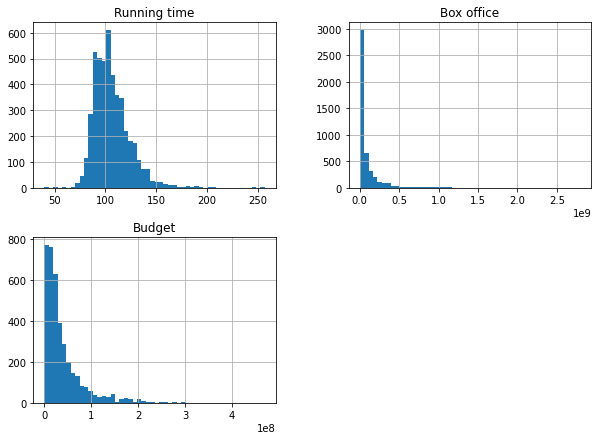

In [30]:
df_num.hist(bins=50, figsize=(10,7))
plt.show()